In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/koreaw/gims_quality.xlsx
/kaggle/input/koreaw/gims_info.xlsx


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 128663 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
한글 폰트 설정이 완료되었습니다.

>>> STEP 1: 데이터 로딩을 시작합니다.
파일 로딩 성공!

>>> STEP 2: 데이터 병합 및 최종 전처리를 시작합니다.
병합 성공! 병합 후 데이터 shape (원본): (38412, 157)


/tmp/ipykernel_13/2115935923.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(['-', 'ND', 'nd'], np.nan)


숫자가 아닌 문자열을 결측치(NaN)로 변환 완료!


/tmp/ipykernel_13/2115935923.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a


>>> STEP 2.5: 고위험 지역 선정을 시작합니다.
TCE 고농도 기준 (상위 5%): 0.0000
고위험 관측소 개수: 395
분석 대상이 '고위험 지역 데이터'로 변경되었습니다. (Shape: (1211, 158))

>>> STEP 3: 고위험 지역 데이터 대상 EDA를 시작합니다.


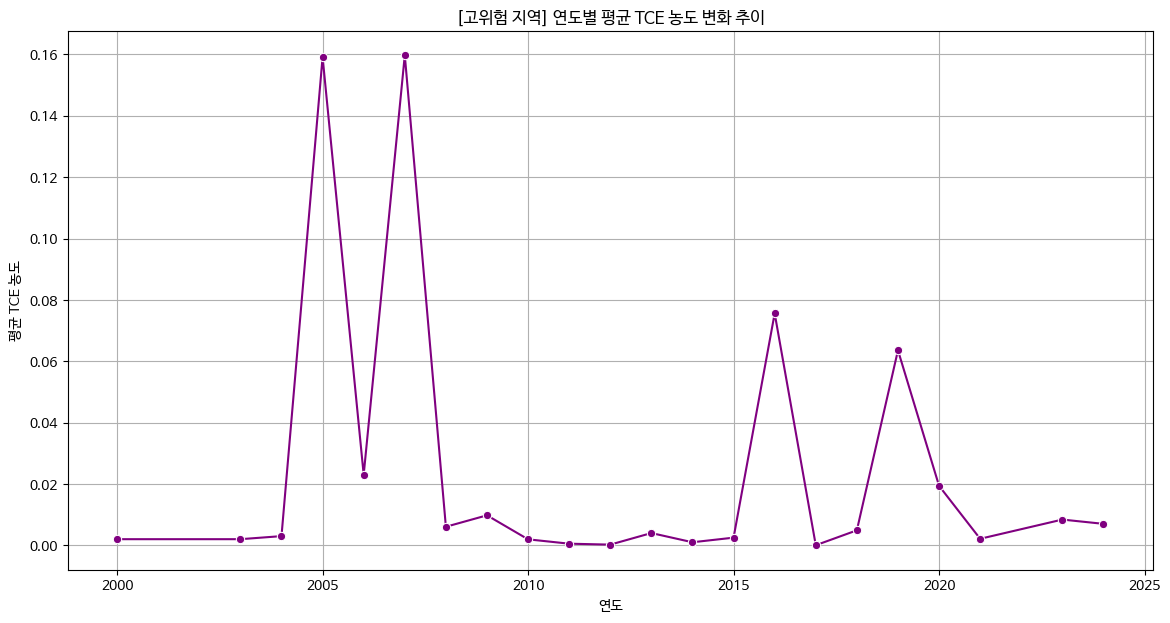

고위험 지역 지도 시각화를 시작합니다...
지도에 표시할 관측소 개수 (좌표 결측치 제거 후): 5



>>> STEP 4: 고위험 지역 대상 AI 예측 모델링을 시작합니다.
Feature Engineering을 시작합니다: 과거(Lag) 및 이동평균(MA) 변수 생성...
모델 학습에 사용되는 최종 Feature: ['연도', '월', 'pH', 'DO', 'EC', '질산성질소', 'TCE_lag1', 'pH_lag1', 'EC_lag1', 'TCE_ma3']
XGBoost 모델 학습 중...


/tmp/ipykernel_13/2115935923.py:126: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model_df.bfill(inplace=True); model_df.ffill(inplace=True)


모델 학습 완료.
[고위험 지역 모델] 테스트 데이터셋에 대한 예측 평균 제곱 오차(MSE): 0.001738


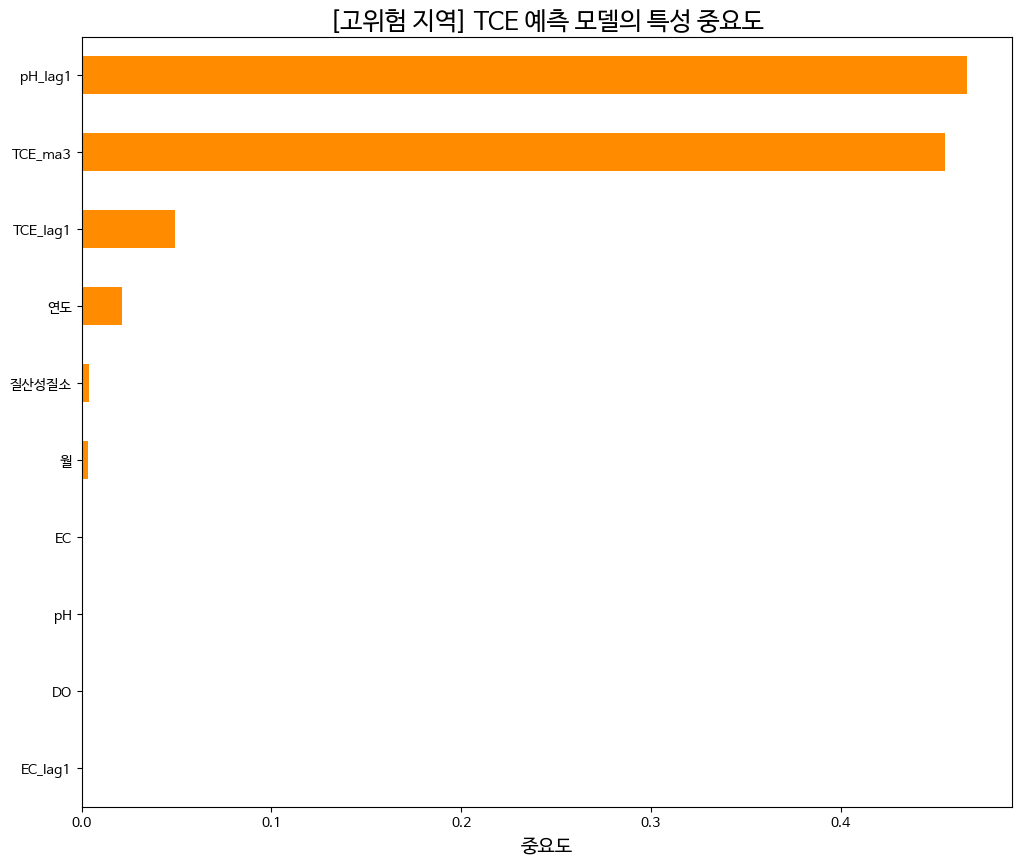


>>> STEP 5: 모델 저장 및 결론
학습된 모델이 'high_risk_tce_predictor.joblib' 파일로 저장되었습니다.

--- 분석 결론 및 제언 ---
...


--- 모든 분석 과정이 성공적으로 완료되었습니다. ---


In [2]:
# ==============================================================================
# STEP 0: 기본 환경 설정 및 라이브러리 임포트
# ==============================================================================
import pandas as pd, numpy as np, sys, joblib
import matplotlib.pyplot as plt, seaborn as sns, folium, geopandas as gpd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# --- Kaggle 환경 한글 폰트 설정 ---
!apt-get update -qq && apt-get install -y fonts-nanum -qq
import matplotlib.font_manager as fm
fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
print("한글 폰트 설정이 완료되었습니다.")


# ==============================================================================
# STEP 1: 데이터 로딩
# ==============================================================================
print("\n>>> STEP 1: 데이터 로딩을 시작합니다.")
INFO_PATH = '/kaggle/input/koreaw/gims_info.xlsx'
QUALITY_PATH = '/kaggle/input/koreaw/gims_quality.xlsx'
INFO_SHEET_NAME = '전국'
QUALITY_SHEET_NAME = '전국DB'

try:
    df_info = pd.read_excel(INFO_PATH, sheet_name=INFO_SHEET_NAME)
    df_quality = pd.read_excel(QUALITY_PATH, sheet_name=QUALITY_SHEET_NAME)
    print("파일 로딩 성공!")
except Exception as e:
    print(f"!!! 에러: 파일 로딩 실패. ({e})"); sys.exit()


# ==============================================================================
# STEP 2: 데이터 병합 및 최종 전처리
# ==============================================================================
print("\n>>> STEP 2: 데이터 병합 및 최종 전처리를 시작합니다.")

# 2.1. 복합 키 병합
MERGE_KEYS = ['시도', '시군구', '읍면동', '리', '번지', 'MW_NAME']
df = pd.merge(df_quality, df_info, on=MERGE_KEYS, how='left', suffixes=('_quality', '_info'))
print(f"병합 성공! 병합 후 데이터 shape (원본): {df.shape}")

# 2.2. 컬럼명 통일 및 고유 ID 생성
rename_dict = {'트리클로로에틸렌_TCE': 'TCE', '질산성질소_NO3_N': '질산성질소'}
df.rename(columns=rename_dict, inplace=True)
df['unique_id'] = df[MERGE_KEYS].astype(str).agg('_'.join, axis=1)

# 2.3. 모든 핵심 분석 변수 정의 및 문자열/결측치 처리
NUMERIC_COLS = ['연도', '수온', 'pH', 'DO', 'EC', 'TCE', '질산성질소', '수위', '심도']
valid_numeric_cols = [col for col in NUMERIC_COLS if col in df.columns]

for col in valid_numeric_cols:
    df[col] = df[col].replace(['-', 'ND', 'nd'], np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')
print("숫자가 아닌 문자열을 결측치(NaN)로 변환 완료!")

df.sort_values(by=['unique_id', '연도'], inplace=True)
df[valid_numeric_cols] = df.groupby('unique_id')[valid_numeric_cols].transform(lambda x: x.ffill().bfill())
for col in valid_numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)
df_processed = df.dropna(subset=valid_numeric_cols).copy()

# 2.4. 고위험 지역 선정
print("\n>>> STEP 2.5: 고위험 지역 선정을 시작합니다.")
if 'TCE' in df_processed.columns:
    high_tce_threshold = df_processed['TCE'].quantile(0.95)
    print(f"TCE 고농도 기준 (상위 5%): {high_tce_threshold:.4f}")
    high_risk_ids = df_processed[df_processed['TCE'] > high_tce_threshold]['unique_id'].unique()
    print(f"고위험 관측소 개수: {len(high_risk_ids)}")
    df_analysis = df_processed[df_processed['unique_id'].isin(high_risk_ids)].copy()
    print(f"분석 대상이 '고위험 지역 데이터'로 변경되었습니다. (Shape: {df_analysis.shape})")
else:
    df_analysis = df_processed.copy()

# ==============================================================================
# STEP 3: 탐색적 데이터 분석 (EDA) - 고위험 지역 대상
# ==============================================================================
print("\n>>> STEP 3: 고위험 지역 데이터 대상 EDA를 시작합니다.")

# 1. 고위험 지역의 TCE 연도별 평균 농도 변화
if 'TCE' in df_analysis.columns and '연도' in df_analysis.columns:
    plt.figure(figsize=(14, 7))
    tce_by_year = df_analysis.groupby('연도')['TCE'].mean()
    sns.lineplot(data=tce_by_year, marker='o', color='purple').set(title='[고위험 지역] 연도별 평균 TCE 농도 변화 추이', xlabel='연도', ylabel='평균 TCE 농도')
    plt.grid(True); plt.show()

# 2. 고위험 지역의 공간 분포 지도 시각화 (★★★★★ 좌표 결측치 처리 강화 ★★★★★)
TM_X_COL, TM_Y_COL = 'TM_X_5186_quality', 'TM_Y_5186_info'
if TM_X_COL not in df.columns: TM_X_COL = 'TM_X_5186'
if TM_Y_COL not in df.columns: TM_Y_COL = 'TM_Y_5186'

if 'TCE' in df_analysis.columns and TM_X_COL in df_analysis.columns and TM_Y_COL in df_analysis.columns:
    print("고위험 지역 지도 시각화를 시작합니다...")
    latest_risk_data = df_analysis.sort_values('연도').drop_duplicates('unique_id', keep='last')
    
    # ★★★ 지도 시각화 직전, 좌표 컬럼의 결측치를 확실하게 제거 ★★★
    map_data = latest_risk_data.dropna(subset=[TM_X_COL, TM_Y_COL]).copy()
    print(f"지도에 표시할 관측소 개수 (좌표 결측치 제거 후): {len(map_data)}")
    
    geodf = gpd.GeoDataFrame(map_data, geometry=gpd.points_from_xy(map_data[TM_X_COL], map_data[TM_Y_COL]), crs='EPSG:5186').to_crs(epsg=4326)
    m = folium.Map(location=[36.5, 127.5], zoom_start=7)
    
    for idx, row in geodf.iterrows():
        tce_val = row['TCE']
        popup_text = f"ID: {row.get('unique_id', 'N/A')}<br>최신 TCE: {tce_val:.4f}"
        folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=6, color='red', fill=True, fill_color='red', fill_opacity=0.7, popup=popup_text).add_to(m)
    display(m)

# ==============================================================================
# STEP 4: AI 모델링 (Feature Engineering 추가 및 고위험 지역 대상)
# ==============================================================================
print("\n>>> STEP 4: 고위험 지역 대상 AI 예측 모델링을 시작합니다.")
target = 'TCE'

model_df = df_analysis.copy()
print("Feature Engineering을 시작합니다: 과거(Lag) 및 이동평균(MA) 변수 생성...")
for col in ['TCE', 'pH', 'EC', '수위']:
    if col in model_df.columns:
        model_df[f'{col}_lag1'] = model_df.groupby('unique_id')[col].shift(1)
model_df['TCE_ma3'] = model_df.groupby('unique_id')['TCE'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
model_df.bfill(inplace=True); model_df.ffill(inplace=True)

if '월' not in model_df.columns: model_df['월'] = (model_df.index % 12) + 1

features = [
    '연도', '월', '수온', 'pH', 'DO', 'EC', '질산성질소', '수위', '심도',
    'TCE_lag1', 'pH_lag1', 'EC_lag1', '수위_lag1', 'TCE_ma3'
]
final_features = [f for f in features if f in model_df.columns]
X = model_df.dropna(subset=final_features + [target])[final_features].astype(float)
y = model_df.dropna(subset=final_features + [target])[target]
print(f"모델 학습에 사용되는 최종 Feature: {final_features}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("XGBoost 모델 학습 중...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5,
                             early_stopping_rounds=50, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
print("모델 학습 완료.")

y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"[고위험 지역 모델] 테스트 데이터셋에 대한 예측 평균 제곱 오차(MSE): {mse:.6f}")

plt.figure(figsize=(12, 10))
feature_importances = pd.Series(xgb_model.feature_importances_, index=final_features)
feature_importances.nlargest(len(final_features)).sort_values().plot(kind='barh', color='darkorange')
plt.title('[고위험 지역] TCE 예측 모델의 특성 중요도', fontsize=18, weight='bold')
plt.xlabel('중요도', fontsize=14)
plt.show()

# ==============================================================================
# STEP 5: 모델 저장 및 결론
# ==============================================================================
print("\n>>> STEP 5: 모델 저장 및 결론")
MODEL_FILENAME = 'high_risk_tce_predictor.joblib'
joblib.dump(xgb_model, MODEL_FILENAME)
print(f"학습된 모델이 '{MODEL_FILENAME}' 파일로 저장되었습니다.")
print("\n--- 분석 결론 및 제언 ---")
print("...")
print("\n\n--- 모든 분석 과정이 성공적으로 완료되었습니다. ---")